In [1]:
!python --version # should say 3.7.16

Python 3.7.16


In [2]:
import os
from agent import Agent
from helper_scripts import evaluate_agents, baseline, create_agents, plot_losses
os.chdir("..")
from rice import Rice

import torch
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import List

/home/ivaylo/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
env = Rice(region_yamls_filename='fewer_region_yamls')
env.num_agents

4

In [4]:
agents = create_agents(env)

In [5]:
def reinforce_batch(agents: List[Agent], n_training_episodes: int, gamma: float, batch_size: int) -> None:
    
    optimizers = [torch.optim.Adam(agent.nets[0].parameters(), lr=.0005) for agent in agents]
    
    losses = [[] for agent in agents]
    
    for batch in tqdm(range(n_training_episodes // batch_size)):
        batch_saved_log_probs = [[[] for _ in range(batch_size)] for agent in agents]
        batch_returns = [[deque(maxlen=env.episode_length) for _ in range(batch_size)] for agent in agents]
        
        # Collect a batch of episodes
        for i_episode in range(batch_size):
            saved_log_probs = [[] for agent in agents]
            rewards = [[] for agent in agents]
            state = env.reset()
            
            # Generate an episode
            for t in range(env.episode_length):
                collective_action = {}
                for agent in agents:
                    action, log_prob = agent.act(0, state[agent.id])
                    saved_log_probs[agent.id].append(log_prob)
                    collective_action[agent.id] = np.array(action)

                state, reward, done, _ = env.step(collective_action)

                for agent in agents:
                    rewards[agent.id].append(reward[agent.id])

            # Calculate discounted returns
            for t in range(env.episode_length)[::-1]:
                for agent in agents:
                    disc_return_t = (batch_returns[agent.id][i_episode][0] 
                                     if len(batch_returns[agent.id][i_episode]) > 0 else 
                                     0)
                    batch_returns[agent.id][i_episode].appendleft(gamma * disc_return_t + rewards[agent.id][t])

            # Store log probs and rewards for the batch
            for agent in agents:
                batch_saved_log_probs[agent.id][i_episode] = saved_log_probs[agent.id]

        # Convert returns to tensors
        batch_returns = [torch.tensor(batch_returns[agent.id]) for agent in agents]
        
        # Standardize returns
        eps = np.finfo(np.float32).eps.item()
        for agent in agents:
            batch_returns[agent.id] = (batch_returns[agent.id] - batch_returns[agent.id].mean()) / (batch_returns[agent.id].std() + eps)
        
        # Calculate loss and update weights for each agent
        for agent in agents:
            # Flatten log probs and returns
            flat_saved_log_probs = [log_prob for ep in batch_saved_log_probs[agent.id] for log_prob in ep]
            flat_batch_returns = batch_returns[agent.id].reshape(-1)
            policy_loss = []
            for log_prob, disc_return in zip(flat_saved_log_probs, flat_batch_returns):
                policy_loss.append(-log_prob * disc_return)
            loss = torch.stack(policy_loss).sum() / batch_size
            losses[agent.id].append(loss.item())

            optimizers[agent.id].zero_grad()
            loss.backward()
            optimizers[agent.id].step()
            
    return losses

In [6]:
losses = reinforce_batch(agents, n_training_episodes=1024, gamma=.9, batch_size=8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:53<00:00,  2.30s/it]


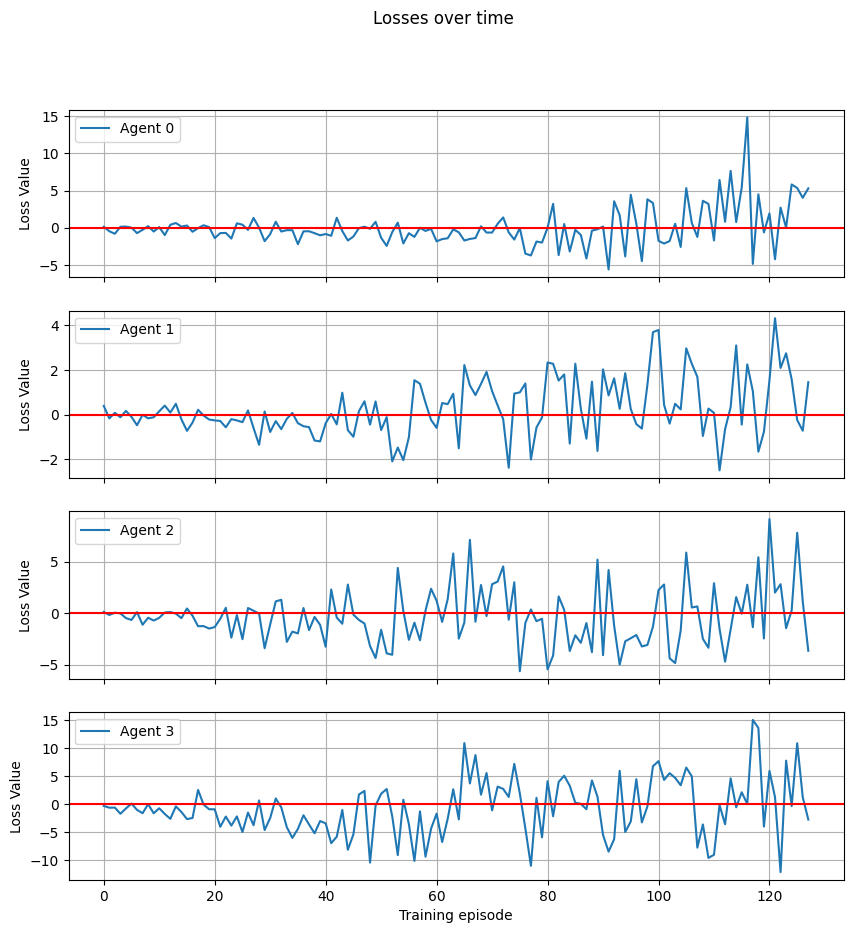

In [7]:
plot_losses(losses)

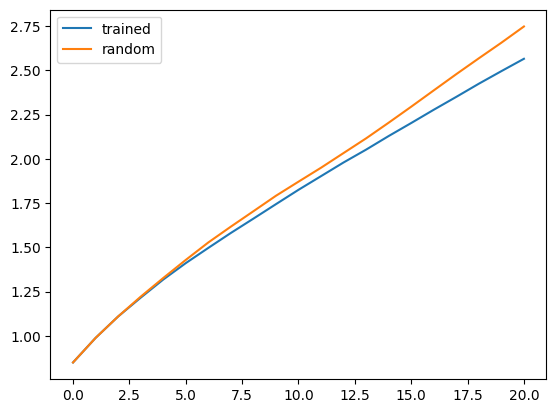

In [10]:
global_state, actions, rewards = evaluate_agents(env, agents)
global_state_baseline, actions_baseline, rewards_baseline = baseline(env)

plt.plot(global_state["global_temperature"]["value"][:, 0], label = "trained")
plt.plot(global_state_baseline["global_temperature"]["value"][:, 0], label = "random")
plt.legend()
plt.show()

In [20]:
os.chdir("new")
for agent in agents:
    torch.save(agent.nets[0].state_dict(), f"agent_{agent.id}.pt")
    print(f"Saved state dict for agent {agent.id}")

Saved state dict for agent 0
Saved state dict for agent 1
Saved state dict for agent 2
Saved state dict for agent 3
